### file import & dataset

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

In [3]:
import warnings # 경고 제거
warnings.filterwarnings('ignore')

In [4]:
test_img_dir = "../data/test"
submission_df = pd.read_csv("../data/sample_submission.csv")

### data 확인

In [6]:
def detect_blur(image_path):
    """Laplacian variance (작을수록 흐림)"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [7]:
def detect_skew_angle(image_path):
    """Hough Transform으로 skew angle 계산"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angles = []
    if lines is not None:
        for rho, theta in lines[:, 0]:
            angle = (theta * 180 / np.pi) - 90
            angles.append(angle)
    if angles:
        return np.median(angles)
    else:
        return 0

In [9]:
def detect_light_spot(image_path):
    """조명 불균형 (좌우, 상하 밝기 차이)"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    left = np.mean(image[:, :image.shape[1]//2])
    right = np.mean(image[:, image.shape[1]//2:])
    top = np.mean(image[:image.shape[0]//2, :])
    bottom = np.mean(image[image.shape[0]//2:, :])
    diff_lr = abs(left - right)
    diff_tb = abs(top - bottom)
    return diff_lr, diff_tb

In [10]:
def detect_noise(image_path):
    """FFT 기반 noise score (분산이 클수록 noise 많음)"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift)+1)
    return np.var(magnitude_spectrum)

In [11]:
def detect_mask_area(image_path):
    """흰색 마스킹 영역 비율"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(image, 245, 255, cv2.THRESH_BINARY)
    white_area_ratio = np.sum(binary == 255) / binary.size
    return white_area_ratio

In [12]:
def detect_motion_blur(image_path):
    """모션 블러 탐지 (edge 방향 std)"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is not None and len(lines) > 0:
        angles = [(theta * 180 / np.pi) for rho, theta in lines[:, 0]]
        return np.std(angles)
    else:
        return 0

In [ ]:
"""
일괄 실행 스크립트
"""

results = []

for img_name in submission_df['ID']:
    img_path = os.path.join(test_img_dir, img_name)
    
    blur_score = detect_blur(img_path)                          # Laplacian variance (작을수록 흐림)            -> 블러(흐림) 탐지
    skew_angle = detect_skew_angle(img_path)                    # Hough Transform으로 skew angle 계산           -> 기울기 및 뒤집힘(회전) 탐지 
    light_lr_diff, light_tb_diff = detect_light_spot(img_path)  # 조명 불균형 (좌우, 상하 밝기 차이)               -> 조명 불균형 탐지
    noise_score = detect_noise(img_path)                        # FFT 기반 noise score (분산이 클수록 noise 많음) -> 노이즈 탐지
    mask_ratio = detect_mask_area(img_path)                     # 흰색 마스킹 영역 비율                           -> 마스킹 영역 탐지
    motion_blur_score = detect_motion_blur(img_path)            # 모션 블러 탐지 (edge 방향 std)                 -> 모션 블러 탐지

    results.append({
        "ID": img_name,
        "blur_score": blur_score,
        "skew_angle": skew_angle,
        "light_lr_diff": light_lr_diff,
        "light_tb_diff": light_tb_diff,
        "noise_score": noise_score,
        "mask_ratio": mask_ratio,
        "motion_blur_score": motion_blur_score
    })

# DataFrame 저장
df_results = pd.DataFrame(results)
df_results.to_csv("test_transform_analysis.csv", index=False)

### 종합 시각화 코드

In [17]:
def plot_histogram(series, title, bins=50):
    plt.figure(figsize=(8, 4))
    plt.hist(series, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

In [16]:
# CSV 읽기
df = pd.read_csv("test_transform_analysis.csv")
df.head()

ID  blur_score  skew_angle  light_lr_diff  light_tb_diff  \
0  0008fdb22ddce0ce.jpg  503.957108  -31.000001      48.898085      44.238269   
1  00091bffdffd83de.jpg  435.535528   45.000000       7.105584       3.907605   
2  00396fbc1f6cc21d.jpg  828.811815   86.000000      34.875603      53.796927   
3  00471f8038d9c4b6.jpg  288.425968   81.999996       3.058760       7.247706   
4  00901f504008d884.jpg  417.489247   74.000000       6.433912       2.347645   

   noise_score  mask_ratio  motion_blur_score  
0   708.605730    0.228423          44.999999  
1   476.741517    0.016695          42.759145  
2   745.512971    0.034726          37.416575  
3   446.197559    0.134844          42.664062  
4   705.594841    0.110422           0.000000

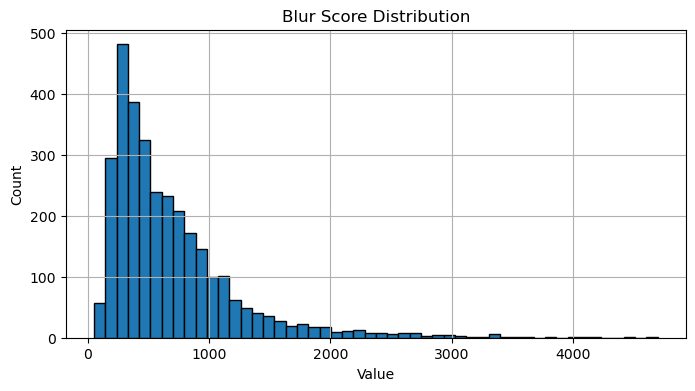

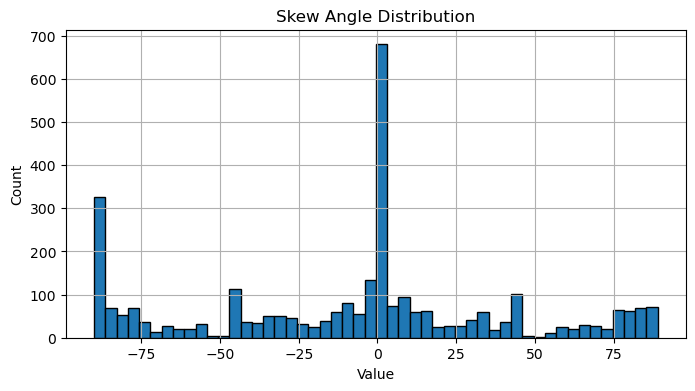

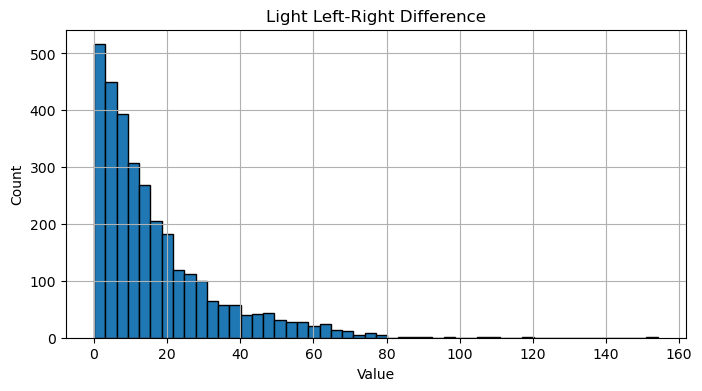

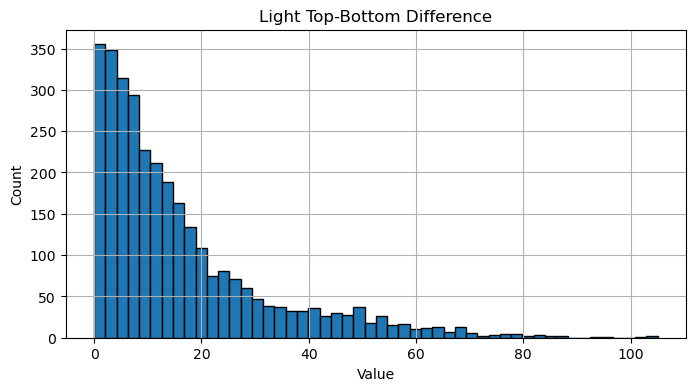

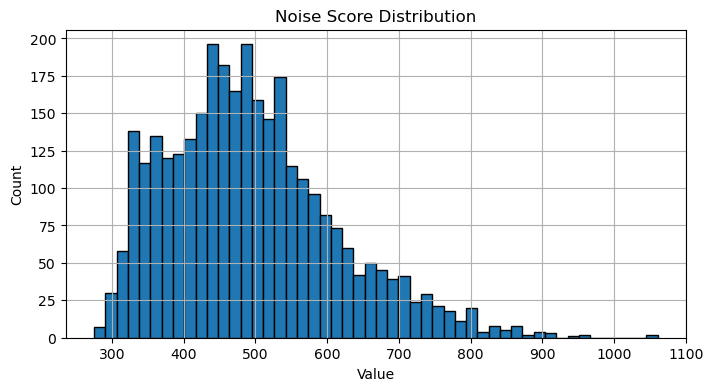

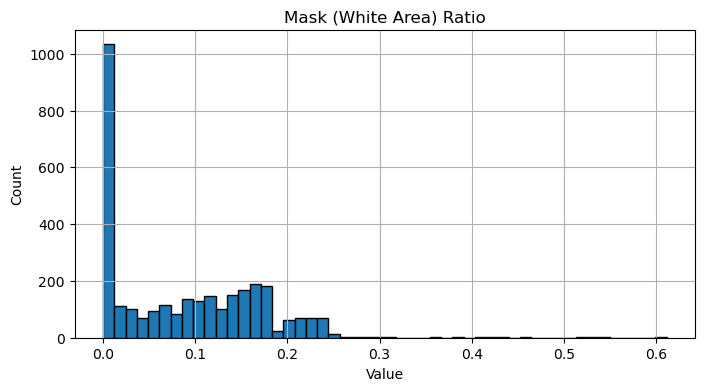

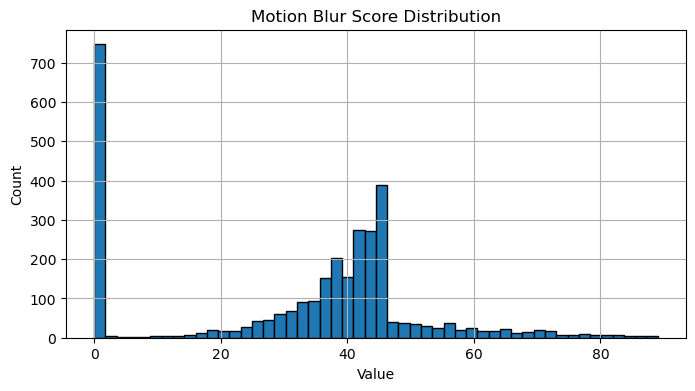

In [18]:
plot_histogram(df['blur_score'], "Blur Score Distribution")
plot_histogram(df['skew_angle'], "Skew Angle Distribution")
plot_histogram(df['light_lr_diff'], "Light Left-Right Difference")
plot_histogram(df['light_tb_diff'], "Light Top-Bottom Difference")
plot_histogram(df['noise_score'], "Noise Score Distribution")
plot_histogram(df['mask_ratio'], "Mask (White Area) Ratio")
plot_histogram(df['motion_blur_score'], "Motion Blur Score Distribution")

### sample image

In [7]:
def show_sample_images_by_score(df, score_column, top_n=5, low=True, title=""):
    """
    score_column 기준으로 상위 or 하위 n개 샘플 이미지 출력
    """
    if low:
        sample_df = df.nsmallest(top_n, score_column)
    else:
        sample_df = df.nlargest(top_n, score_column)

    plt.figure(figsize=(15, 3))
    for i, row in enumerate(sample_df.itertuples()):
        img_path = os.path.join(test_img_dir, row.ID)
        img = Image.open(img_path)

        plt.subplot(1, top_n, i + 1)
        plt.imshow(img)
        plt.title(f"{score_column}: {getattr(row, score_column):.1f}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [5]:
# 예시 호출
df = pd.read_csv("test_transform_analysis.csv")

1. Blur score에 따른 샘플 예시 이미지 출력

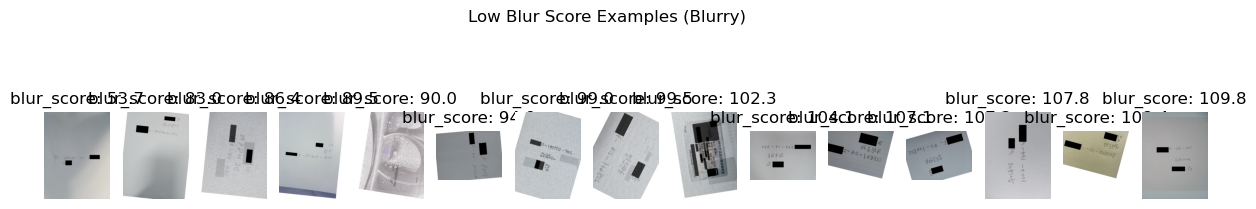

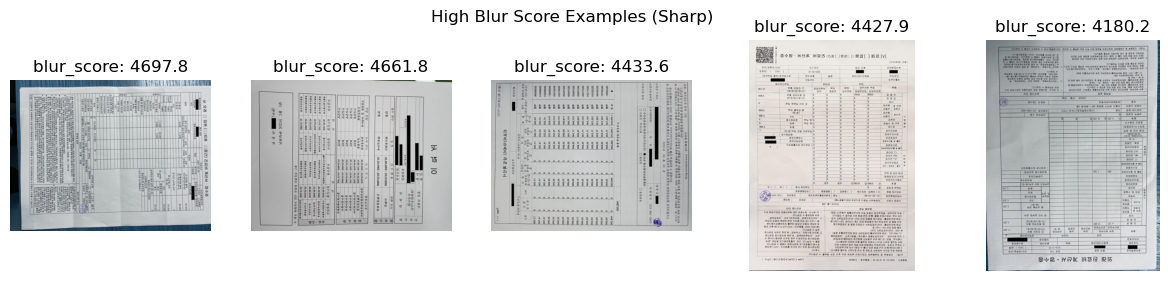

In [25]:
show_sample_images_by_score(df, "blur_score", top_n=15, low=True, title="Low Blur Score Examples (Blurry)")
show_sample_images_by_score(df, "blur_score", top_n=5, low=False, title="High Blur Score Examples (Sharp)")

2. Light 차이 score로 샘플 예시 이미지 출력

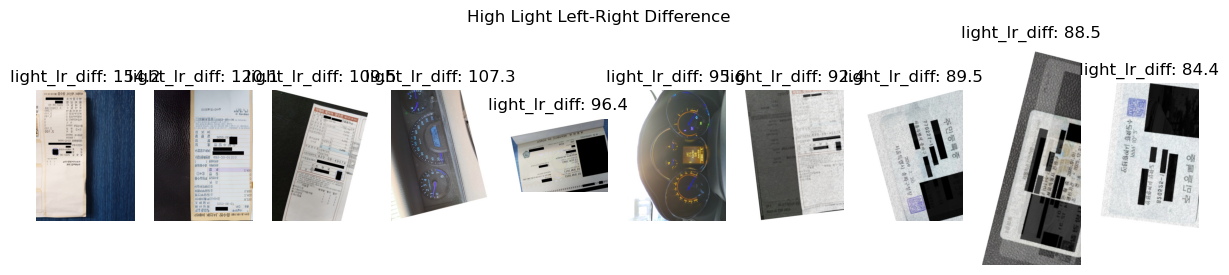

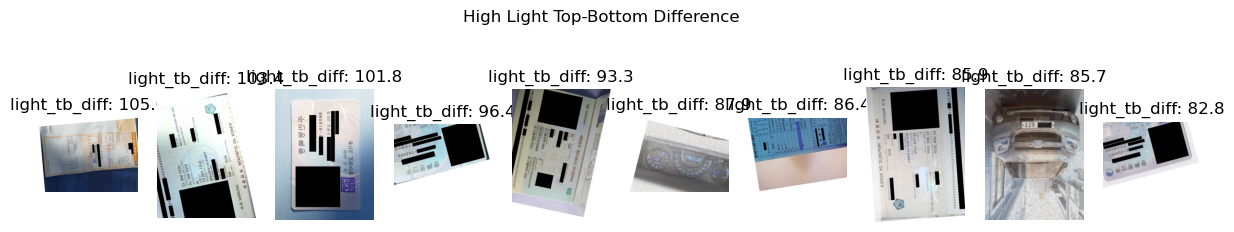

In [24]:
# 좌우 밝기 차이 기준 예시
show_sample_images_by_score(df, "light_lr_diff", top_n=10, low=False, title="High Light Left-Right Difference")

# 상하 밝기 차이 기준 예시
show_sample_images_by_score(df, "light_tb_diff", top_n=10, low=False, title="High Light Top-Bottom Difference")

3. Noise score에 따른 샘플 예시 이미지 출력

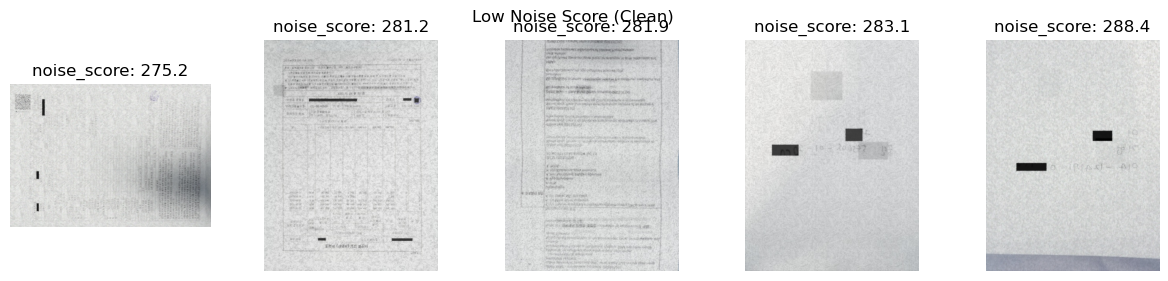

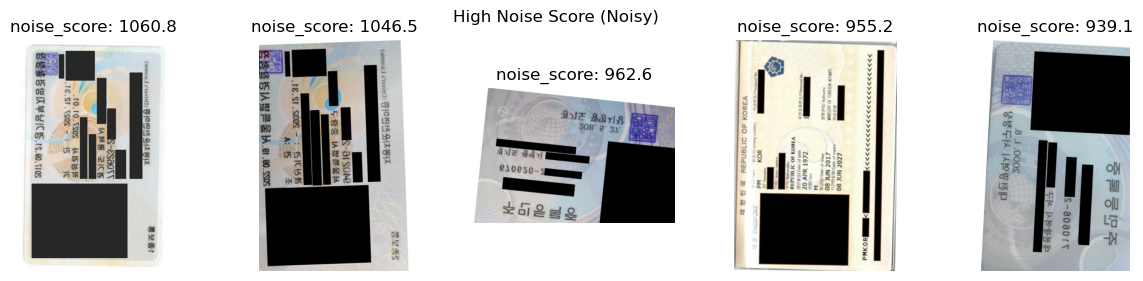

In [8]:
show_sample_images_by_score(df, "noise_score", top_n=5, low=True, title="Low Noise Score (Clean)")
show_sample_images_by_score(df, "noise_score", top_n=5, low=False, title="High Noise Score (Noisy)")

4. Mask ratio 상위 샘플 이미지 grid 시각화

In [29]:
def show_mask_ratio_top(df, top_n=9):
    sample_df = df.nlargest(top_n, "mask_ratio")
    grid_size = int(np.ceil(np.sqrt(top_n)))

    plt.figure(figsize=(grid_size * 3, grid_size * 3))
    for i, row in enumerate(sample_df.itertuples()):
        img_path = os.path.join(test_img_dir, row.ID)
        img = Image.open(img_path)

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img)
        plt.title(f"Mask: {row.mask_ratio:.2f}")
        plt.axis('off')
    plt.suptitle("Top Mask Ratio Images")
    plt.show()

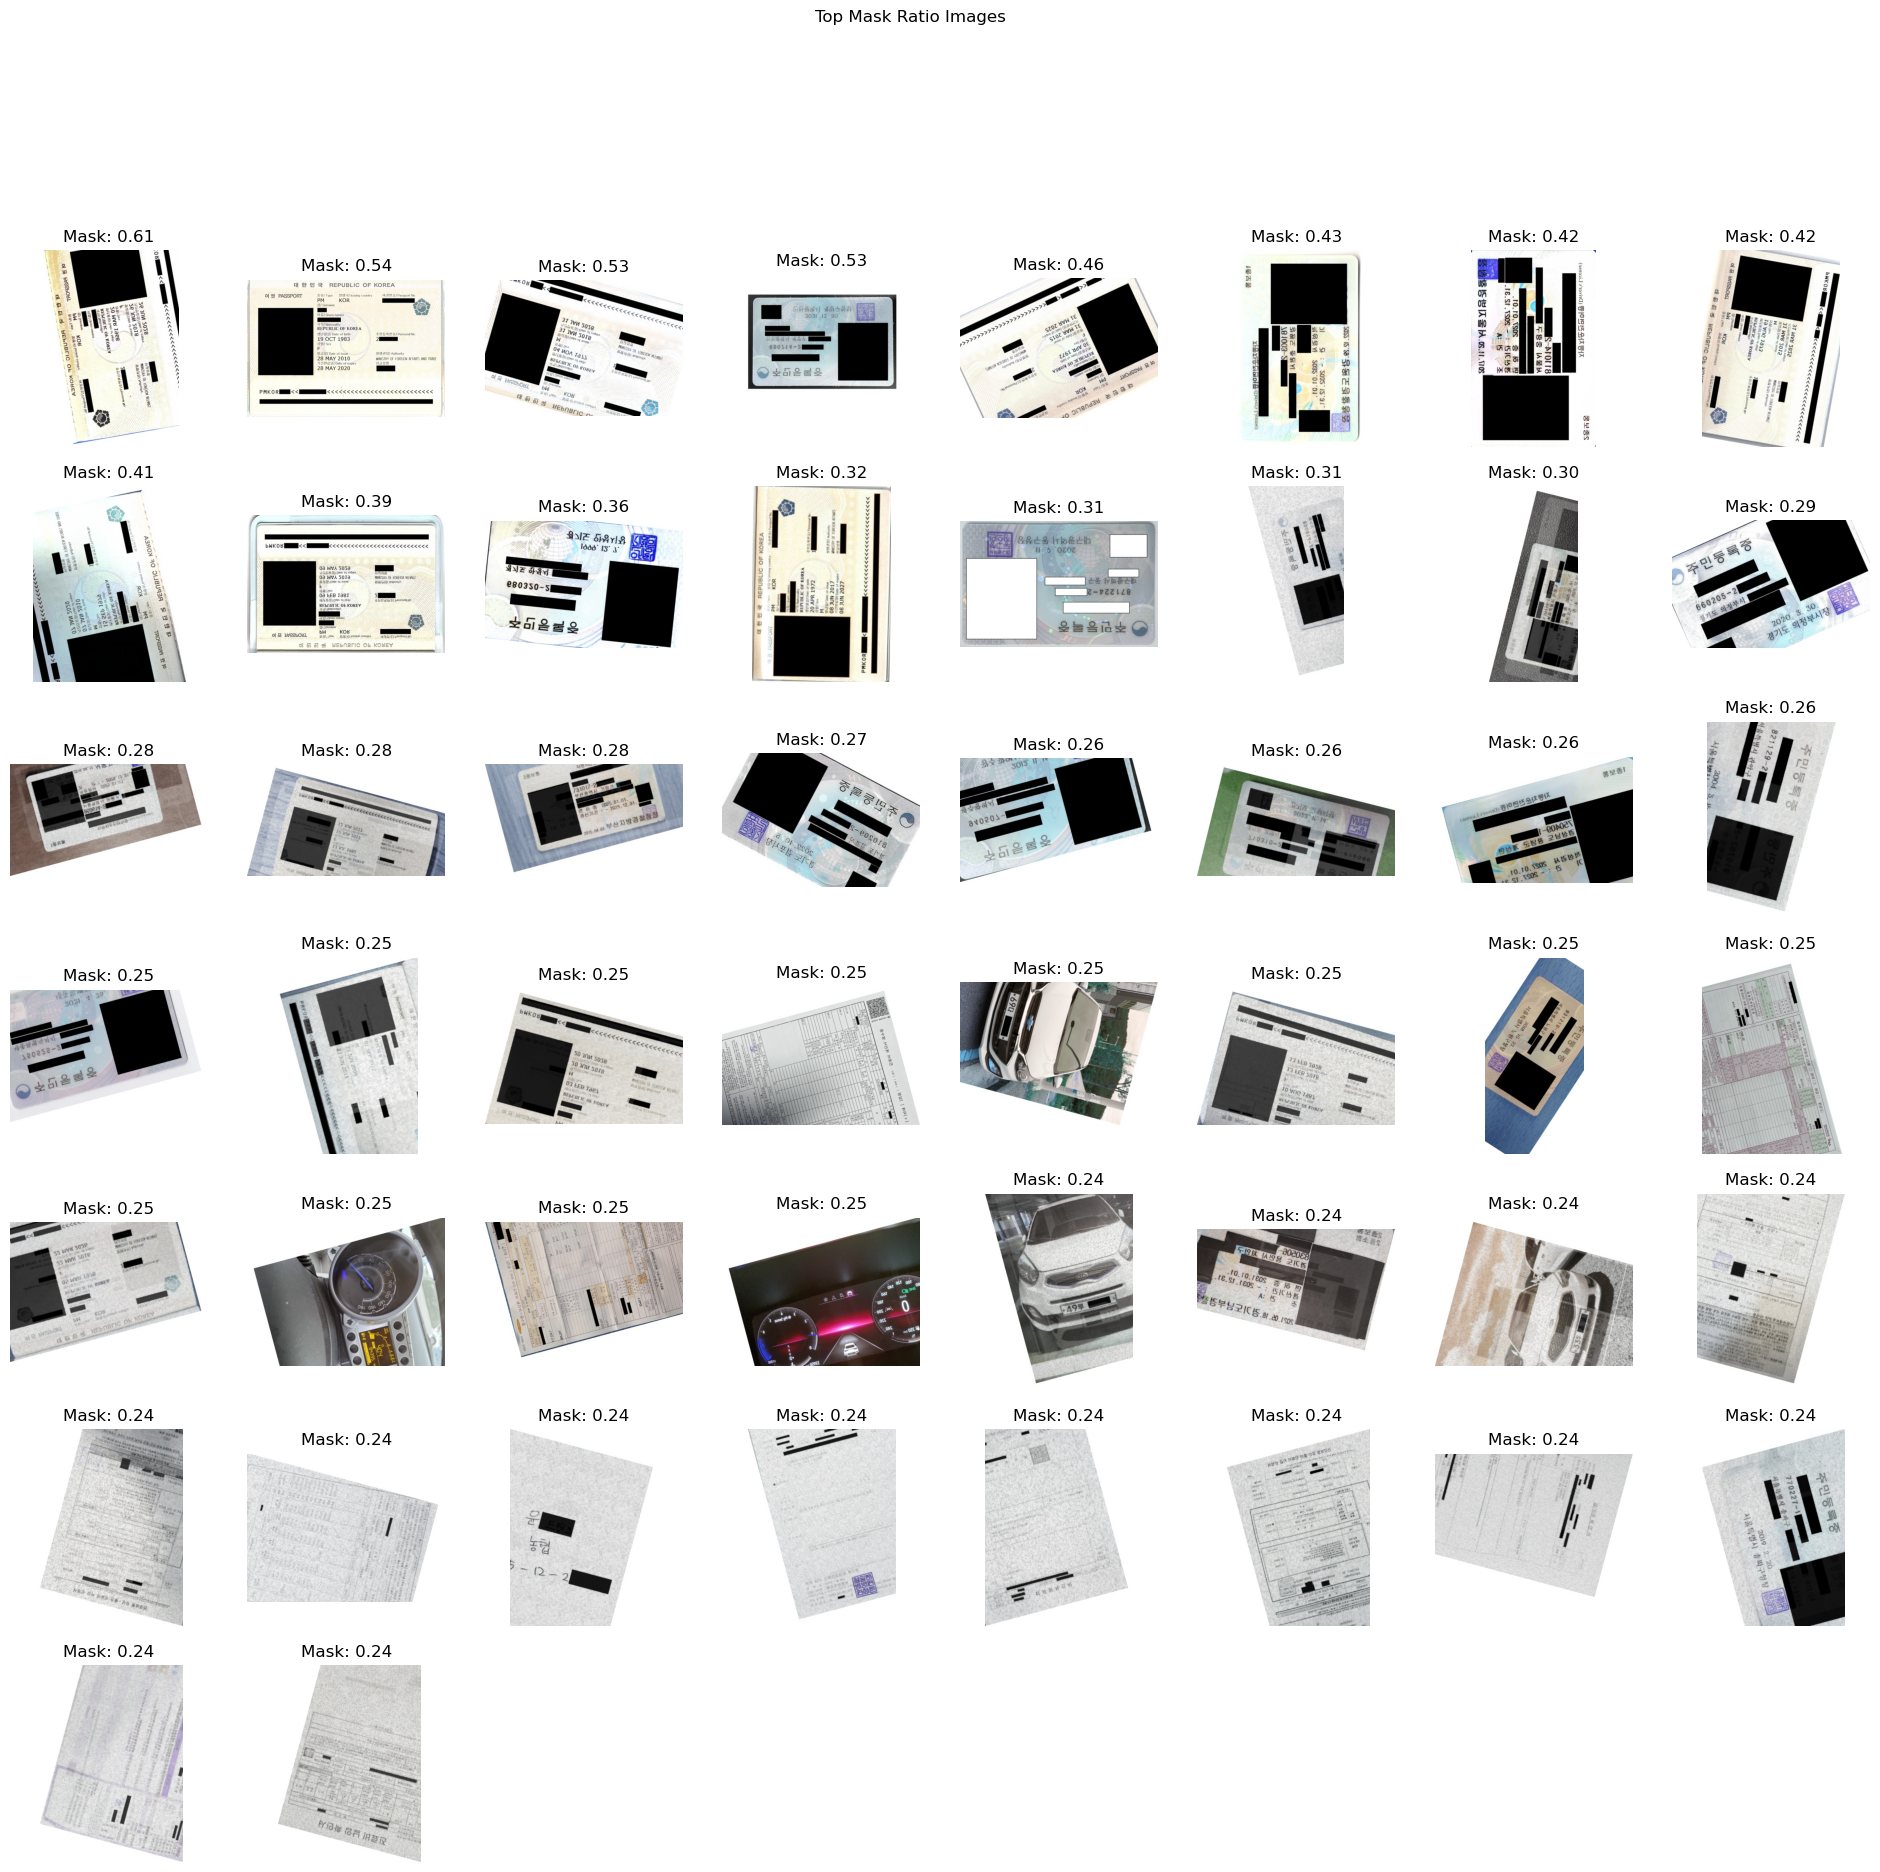

In [32]:
show_mask_ratio_top(df, top_n=50)

5. Skew angle 정도에 따른 샘플 예시 이미지 출력

In [14]:
# 절대값 컬럼 추가
df["abs_skew_angle"] = df["skew_angle"].abs()

def show_skew_angle_samples(df, top_n=5, low=True, title=""):
    """
    skew_angle 기준으로 상위 또는 하위 n개 샘플 이미지 출력
    low=True → 작은 skew angle (정방향)
    low=False → 큰 skew angle (많이 기울어진)
    """
    if low:
        sample_df = df.nsmallest(top_n, "abs_skew_angle")
    else:
        sample_df = df.nlargest(top_n, "abs_skew_angle")

    plt.figure(figsize=(15, 3))
    for i, row in enumerate(sample_df.itertuples()):
        img_path = os.path.join(test_img_dir, row.ID)
        img = Image.open(img_path)

        plt.subplot(1, top_n, i + 1)
        plt.imshow(img)
        plt.title(f"Angle: {row.skew_angle:.1f}°")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


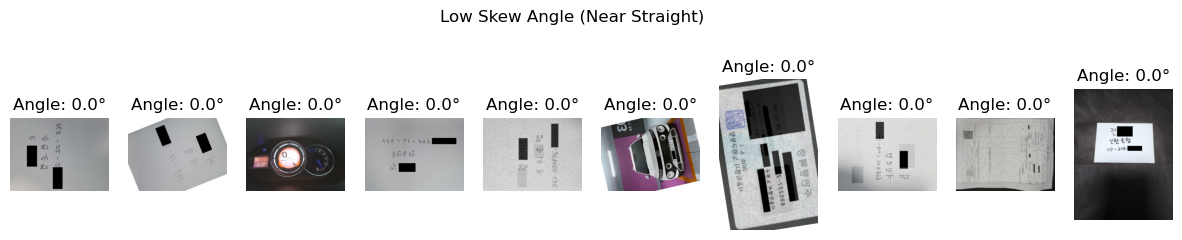

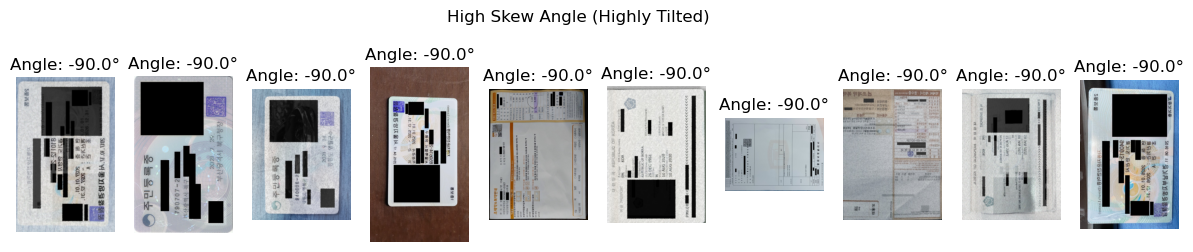

In [23]:
show_skew_angle_samples(df, top_n=10, low=True, title="Low Skew Angle (Near Straight)")
show_skew_angle_samples(df, top_n=10, low=False, title="High Skew Angle (Highly Tilted)")

6. Motion blur (edge 방향 std) 정도에 따른 샘플 예시 이미지 출력

In [16]:
def show_motion_blur_samples(df, top_n=5, low=True, title=""):
    """
    motion_blur_score 기준으로 상위 또는 하위 n개 샘플 이미지 출력
    low=True → 낮은 std (한쪽으로 edge가 몰림 → 강한 motion blur)
    low=False → 높은 std (edge 방향 다양 → 상대적으로 선명)
    """
    if low:
        sample_df = df.nsmallest(top_n, "motion_blur_score")
    else:
        sample_df = df.nlargest(top_n, "motion_blur_score")

    plt.figure(figsize=(15, 3))
    for i, row in enumerate(sample_df.itertuples()):
        img_path = os.path.join(test_img_dir, row.ID)
        img = Image.open(img_path)

        plt.subplot(1, top_n, i + 1)
        plt.imshow(img)
        plt.title(f"Std: {row.motion_blur_score:.1f}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

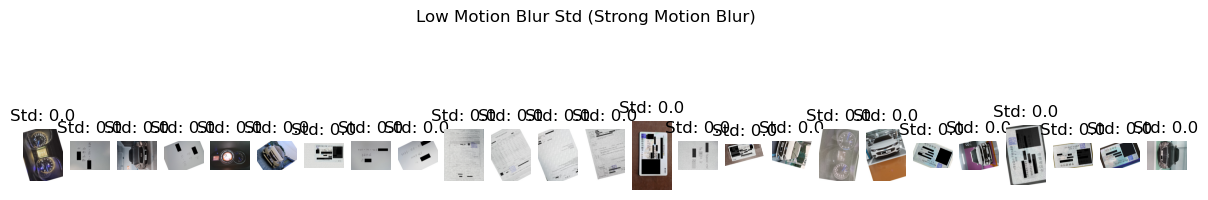

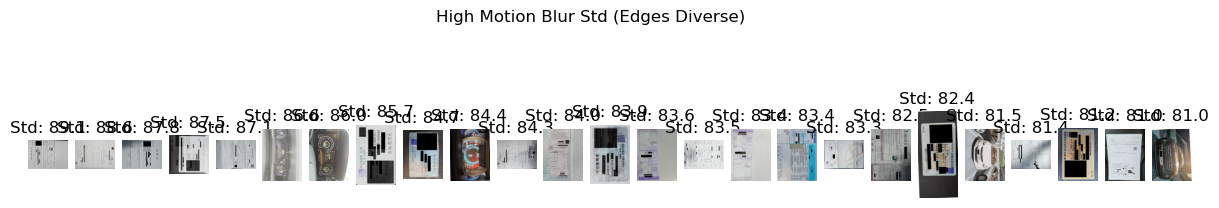

In [27]:
show_motion_blur_samples(df, top_n=25, low=True, title="Low Motion Blur Std (Strong Motion Blur)")
show_motion_blur_samples(df, top_n=25, low=False, title="High Motion Blur Std (Edges Diverse)")

### 변형 간 상관분석 : Mask ratio, blur, noise, motion blur

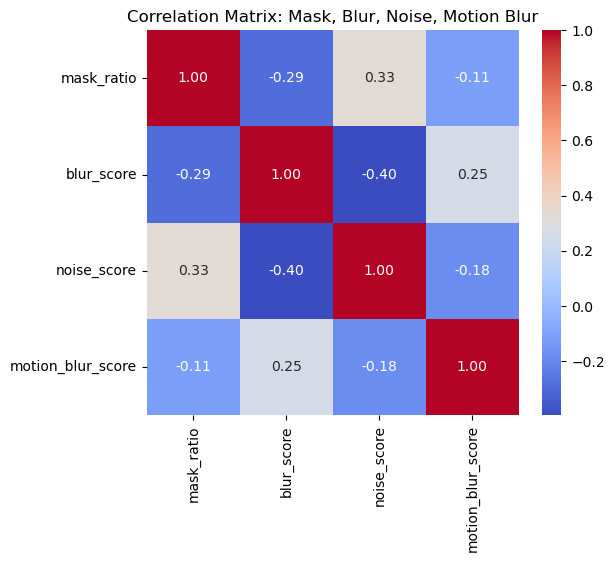

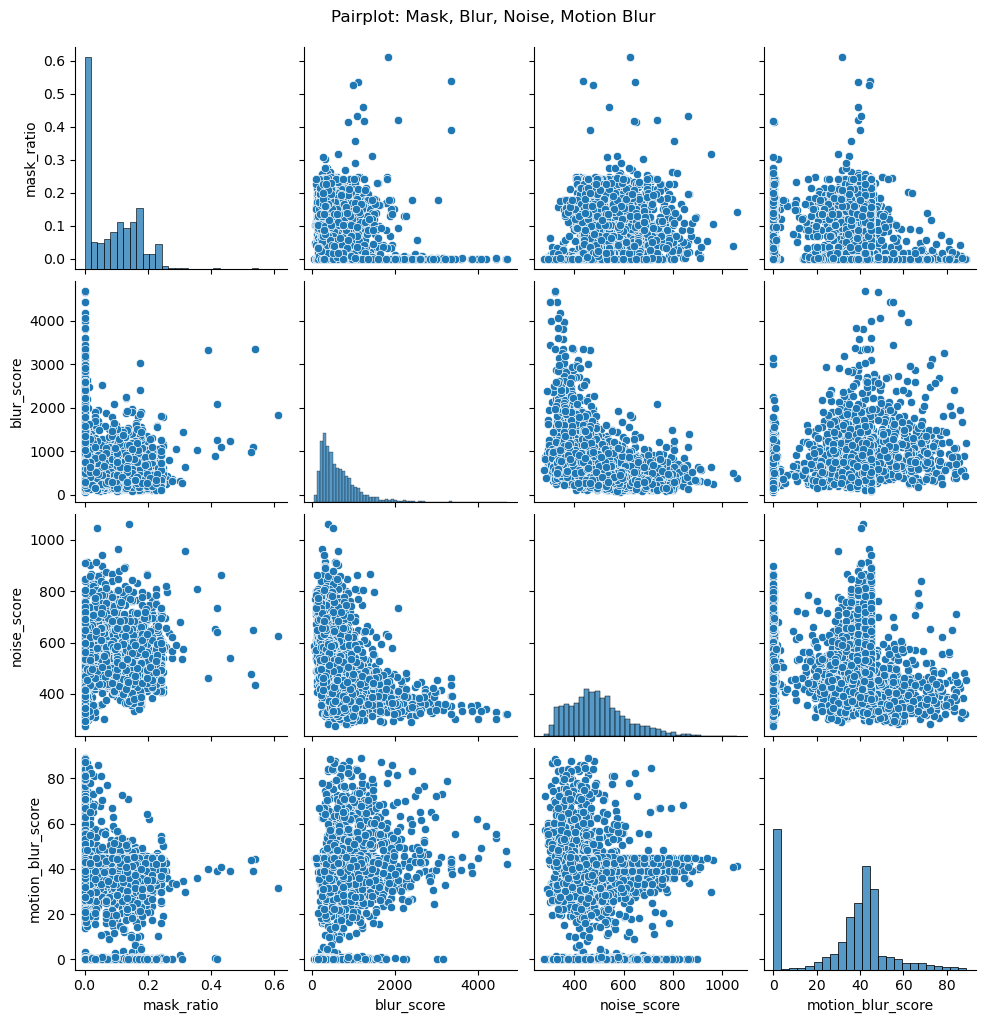

In [19]:
# 상관 계수 계산
selected_cols = ["mask_ratio", "blur_score", "noise_score", "motion_blur_score"]
corr_matrix = df[selected_cols].corr()

# 히트맵 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: Mask, Blur, Noise, Motion Blur")
plt.show()

# 페어플롯 (scatter 조합)
sns.pairplot(df[selected_cols])
plt.suptitle("Pairplot: Mask, Blur, Noise, Motion Blur", y=1.02)
plt.show()

### 변형 조합 시각화

In [40]:
def show_combination_samples(
    df,
    condition_name,
    blur_thresh=None,
    noise_thresh=None,
    mask_thresh=None,
    motion_blur_thresh=None,
    skew_thresh=None,
    top_n=9
):
    # 절대 skew angle 컬럼 생성
    if "abs_skew_angle" not in df.columns:
        df["abs_skew_angle"] = df["skew_angle"].abs()

    condition = pd.Series(True, index=df.index)

    if blur_thresh is not None:
        condition &= df["blur_score"] < blur_thresh
    if noise_thresh is not None:
        condition &= df["noise_score"] > noise_thresh
    if mask_thresh is not None:
        condition &= df["mask_ratio"] > mask_thresh
    if motion_blur_thresh is not None:
        condition &= df["motion_blur_score"] < motion_blur_thresh
    if skew_thresh is not None:
        condition &= df["abs_skew_angle"] > skew_thresh

    sample_df = df[condition]

    if sample_df.empty:
        print(f"⚠️ 조건에 맞는 샘플이 없습니다: {condition_name}")
        return

    # noise_score 기준 상위 top_n 선택 (조건부로 row 수가 적으면 전부)
    sample_df = sample_df.sort_values(by="noise_score", ascending=False).head(top_n)

    grid_size = int(np.ceil(np.sqrt(len(sample_df))))
    plt.figure(figsize=(grid_size * 3, grid_size * 3))

    for i, row in enumerate(sample_df.itertuples()):
        img_path = os.path.join(test_img_dir, row.ID)
        img = Image.open(img_path)

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img)
        plt.title(f"b:{row.blur_score:.0f}\nn:{row.noise_score:.0f}\nm:{row.mask_ratio:.2f}\nmb:{row.motion_blur_score:.1f}")
        plt.axis('off')

    plt.suptitle(condition_name)
    plt.tight_layout()
    plt.show()

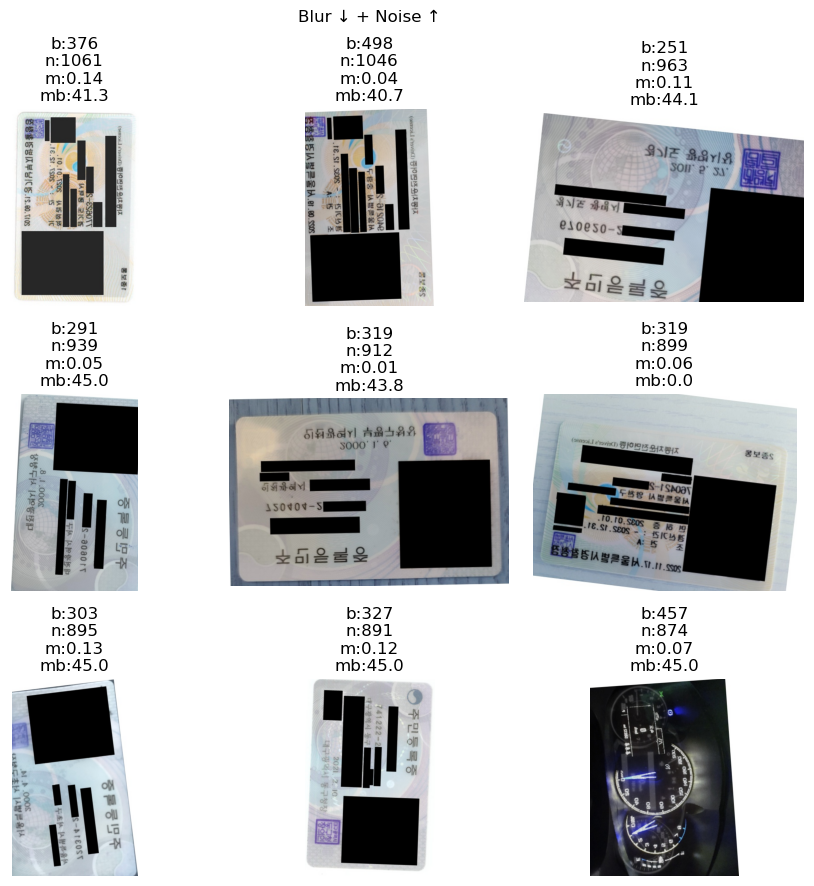

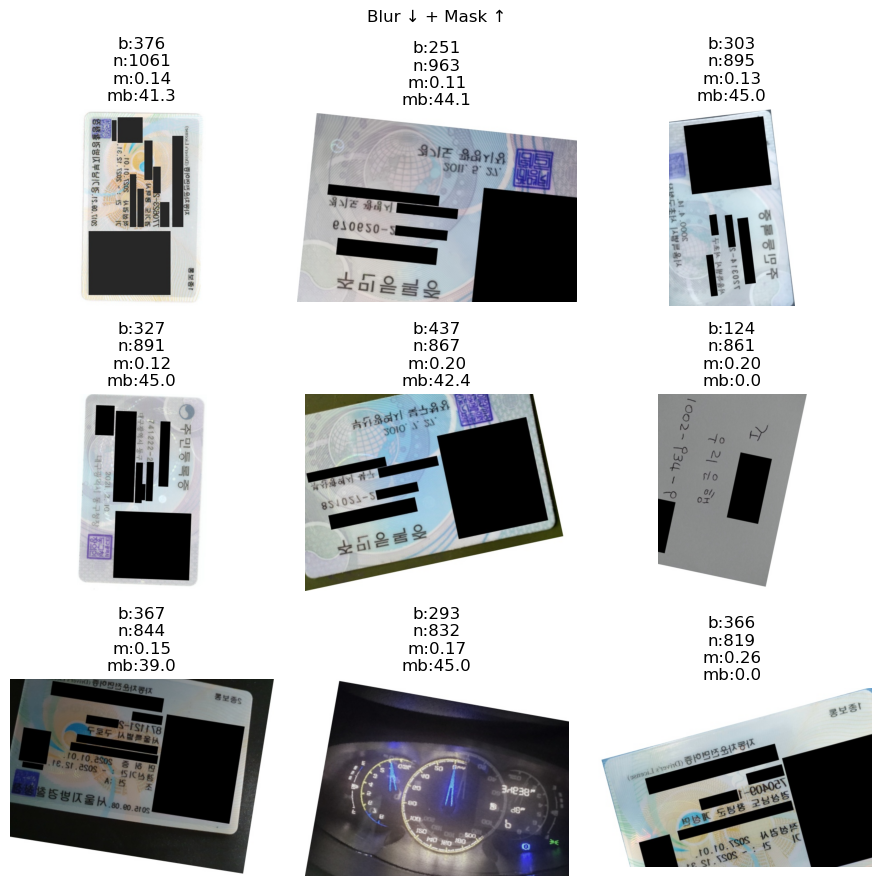

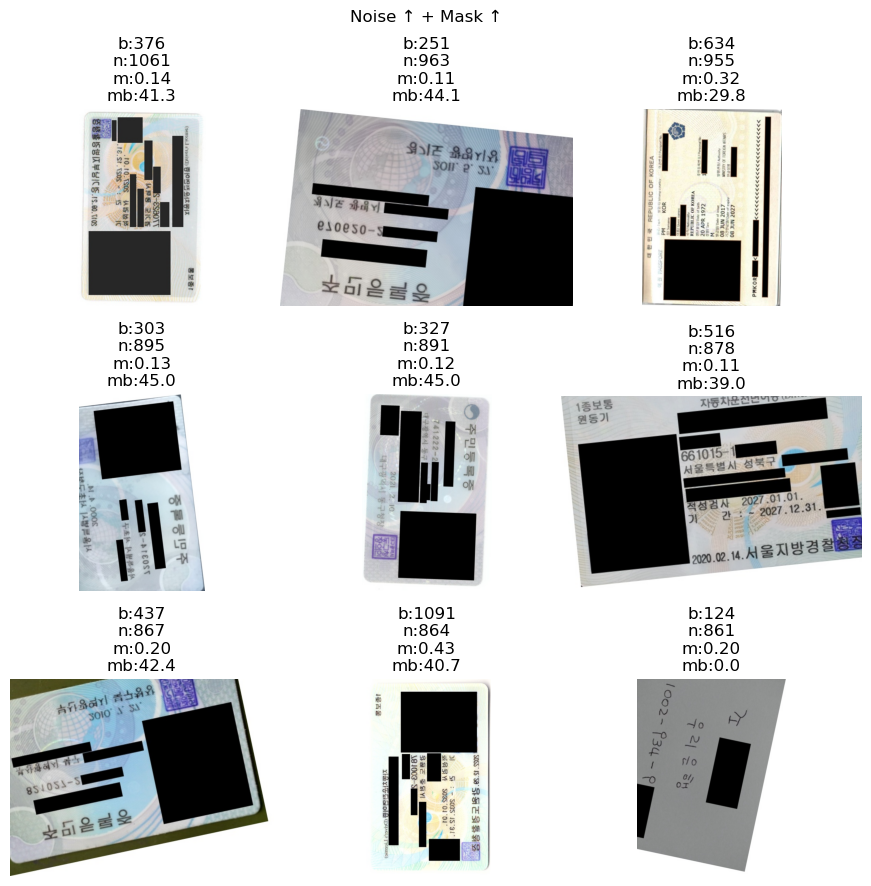

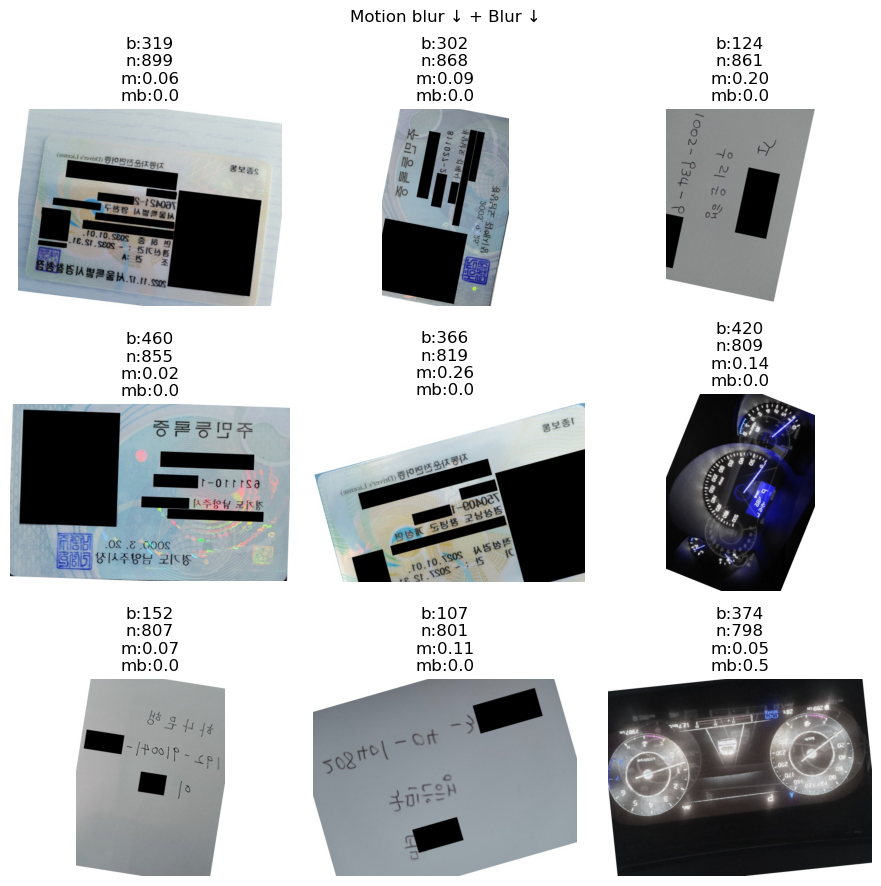

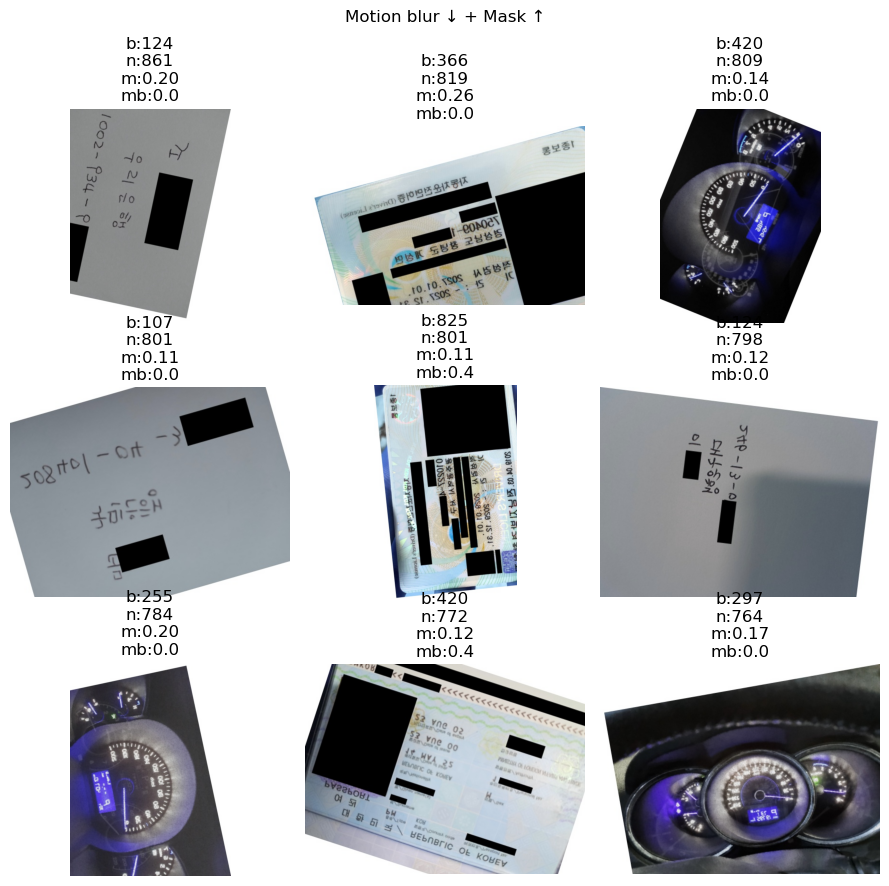

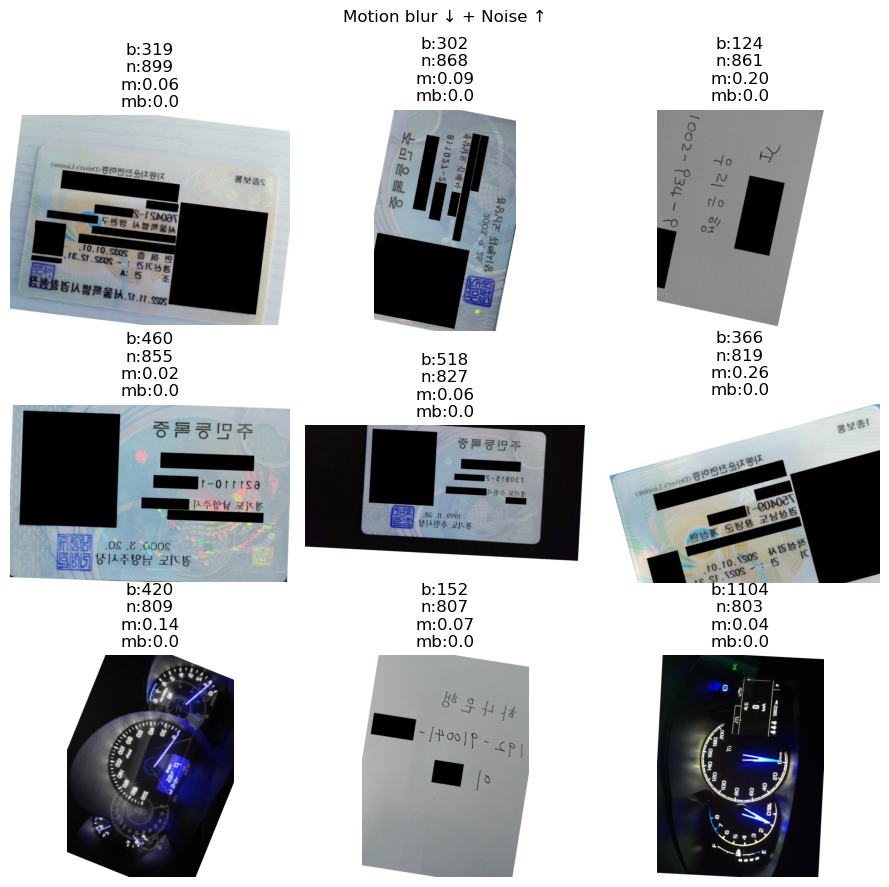

In [41]:
show_combination_samples(df, "Blur ↓ + Noise ↑", blur_thresh=500, noise_thresh=800, top_n=9)
show_combination_samples(df, "Blur ↓ + Mask ↑", blur_thresh=500, mask_thresh=0.1, top_n=9)
show_combination_samples(df, "Noise ↑ + Mask ↑", noise_thresh=800, mask_thresh=0.1, top_n=9)
show_combination_samples(df, "Motion blur ↓ + Blur ↓", motion_blur_thresh=20, blur_thresh=500, top_n=9)
show_combination_samples(df, "Motion blur ↓ + Mask ↑", motion_blur_thresh=20, mask_thresh=0.1, top_n=9)
show_combination_samples(df, "Motion blur ↓ + Noise ↑", motion_blur_thresh=20, noise_thresh=800, top_n=9)

### 변형 비율 확인

1️⃣ "변형 score" 기반 threshold 분할

<small>
각 변형 score (예: blur score, noise score 등)에 대해 threshold를 설정하고, 이를 기준으로 변형 여부를 이진화한다.

예를 들어:
- Blur score: threshold 이하 → "흐린 이미지"로 간주
- Noise score: threshold 이상 → "노이즈 많은 이미지"
- Skew angle: threshold 이상 → "기울어진 이미지"
- Mask ratio: threshold 이상 → "마스킹된 이미지"
- Motion blur score: threshold 이하 → "motion blur 강한 이미지"
</small>


2️⃣ 비율 계산

<small>
각 score에 대해 "변형이 적용된" 샘플 개수를 전체 샘플 개수로 나누어 **비율(%)**을 구한다.
</small>

In [42]:
def calculate_transformation_ratios(
    df,
    blur_thresh=500,
    noise_thresh=800,
    skew_thresh=30,
    mask_thresh=0.1,
    motion_blur_thresh=20
):
    total = len(df)

    # Skew 절대값
    df["abs_skew_angle"] = df["skew_angle"].abs()

    # 각 변형 적용 여부
    blur_count = (df["blur_score"] < blur_thresh).sum()
    noise_count = (df["noise_score"] > noise_thresh).sum()
    skew_count = (df["abs_skew_angle"] > skew_thresh).sum()
    mask_count = (df["mask_ratio"] > mask_thresh).sum()
    motion_blur_count = (df["motion_blur_score"] < motion_blur_thresh).sum()

    # 비율 계산
    ratios = {
        "Blur (흐림)": f"{blur_count / total * 100:.1f}%",
        "Noise (노이즈)": f"{noise_count / total * 100:.1f}%",
        "Skew angle (기울기)": f"{skew_count / total * 100:.1f}%",
        "Masking (마스킹)": f"{mask_count / total * 100:.1f}%",
        "Motion blur": f"{motion_blur_count / total * 100:.1f}%"
    }

    return ratios

In [43]:
ratios = calculate_transformation_ratios(df)
print("✅ Test 데이터 변형 비율:")
for k, v in ratios.items():
    print(f"{k}: {v}")

✅ Test 데이터 변형 비율:
Blur (흐림): 47.7%
Noise (노이즈): 1.6%
Skew angle (기울기): 50.7%
Masking (마스킹): 43.9%
Motion blur: 25.9%
